In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
import pywt

In [2]:
from SimpleSpeechCommands import get_word_dict, read_list, load_data
from SimpleSpeechCommands import append_examples,partition_directory

In [3]:
word_to_label,label_to_word = get_word_dict()
path_dataset = '/home/edoardobucheli/TFSpeechCommands/train/audio'
#path_dataset = '/Users/edoardobucheli/Documents/MCC/Tesis/Kaggle_SpeechCommands/train/audio'
sr = 16000
file_length = 16000

In [4]:
training_files = read_list(path_dataset,'training_files.txt')
validation_files = read_list(path_dataset,'validation_files.txt')
testing_files = read_list(path_dataset,'testing_files.txt')

In [5]:
x_train,y_train = load_data(training_files,sr,file_length,path_dataset,word_to_label)
x_val,y_val = load_data(validation_files,sr,file_length,path_dataset,word_to_label)
x_test,y_test = load_data(testing_files,sr,file_length,path_dataset,word_to_label)

100%|██████████| 3430/3430 [00:01<00:00, 2949.95it/s]


In [6]:
backgrounds = partition_directory(path_dataset,'_background_noise_',sr,file_length)

In [7]:
x_train,y_train = append_examples(x_train,y_train,backgrounds[:300],11)
x_val,y_val = append_examples(x_val,y_val,backgrounds[300:320],11)
x_test,y_test = append_examples(x_test,y_test,backgrounds[320:],11)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(25412, 16000)
(25412,)
(3444, 16000)
(3444,)
(3508, 16000)
(3508,)


### Preprocess Data

In [9]:
from pywt import wavedec
from tqdm import tqdm

In [10]:
test = wavedec(x_train[0],'db4',)

In [11]:
new_test = [f for l in test for f in l]

In [12]:
levels = len(test)
print(levels)
res = len(new_test)
print(res)

12
16070


In [13]:
x_train_2 = np.zeros((len(x_train),levels,14))

for n, example in enumerate(tqdm(x_train)):
    
    wt_this =  wavedec(example,'db4')
    
    for i,wave in enumerate(wt_this):
        
        wave /= np.max(np.absolute(wave))
        wave_split = np.array_split(wave,14)

        for j,subwave in enumerate(wave_split):
            
            x_train_2[n,i,j] = np.sum(np.square(subwave))

100%|██████████| 25412/25412 [00:32<00:00, 790.60it/s]


In [14]:
x_val_2 = np.zeros((len(x_val),levels,14))

for n, example in enumerate(tqdm(x_val)):
    
    wt_this =  wavedec(example,'db4')
    
    for i,wave in enumerate(wt_this):
        
        wave /= np.max(np.absolute(wave))
        wave_split = np.array_split(wave,14)

        for j,subwave in enumerate(wave_split):
            
            x_val_2[n,i,j] = np.sum(np.square(subwave))
            #x_val_2[n,i,j] = np.mean(subwave)

100%|██████████| 3444/3444 [00:04<00:00, 803.05it/s]


In [15]:
from ProcessAudio import normalize_2D, normalize_spectrograms

In [16]:
x_train_2 = normalize_spectrograms(np.log(x_train_2+1e-10))
x_val_2 = normalize_spectrograms(np.log(x_val_2+1e-10))

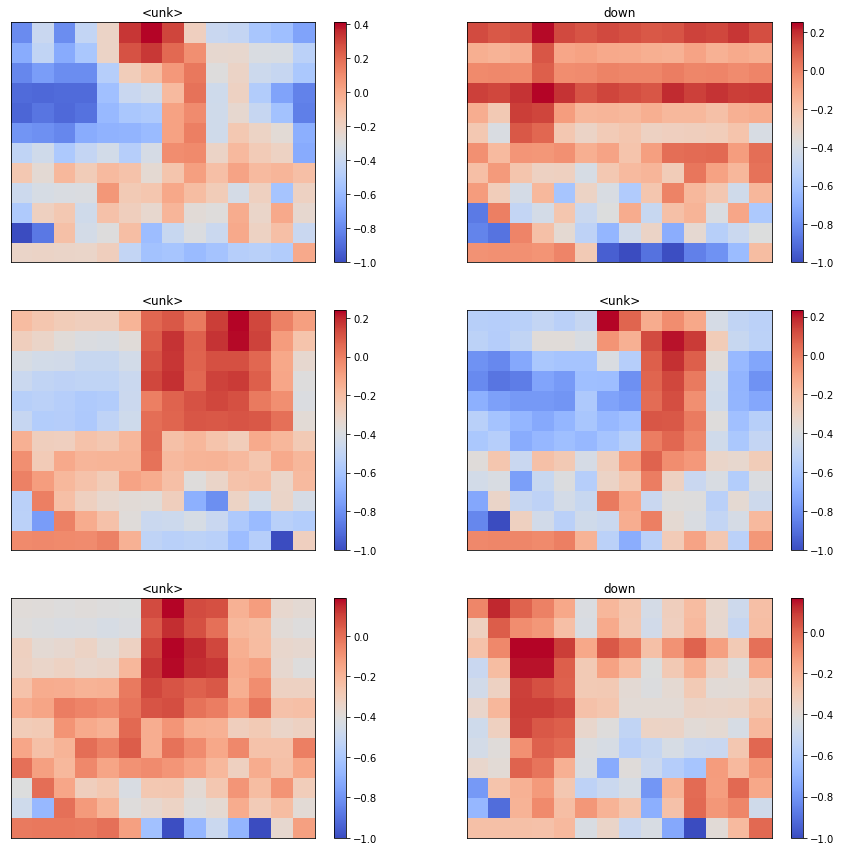

In [17]:
plt.figure(figsize = (15,15))

for i in range(1,7):
    ind = np.random.randint(0,len(x_train_2))
    
    plt.subplot(3,2,i)
    librosa.display.specshow(x_train_2[ind])
    plt.title(label_to_word[y_train[ind]])
    plt.colorbar()

## Other Processing

In [18]:
file_length = res

In [19]:
from Utilities import make_oh

In [20]:
N_train, _,_ = x_train_2.shape
N_val, _,_ = x_val_2.shape
#N_test, _ = x_test_2.shape

n_classes = len(np.unique(y_train))

In [21]:
y_train_oh = make_oh(y_train)
y_val_oh = make_oh(y_val)
#y_test_oh = make_oh(y_test)

In [22]:
print(x_train_2.shape)
print(y_train_oh.shape)
print(x_val_2.shape)
print(y_val_oh.shape)
#print(x_test.shape)
#print(y_test_oh.shape)

(25412, 12, 14)
(25412, 12)
(3444, 12, 14)
(3444, 12)


## CRNN

In [23]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, CuDNNGRU
from tensorflow.keras.layers import Lambda, Conv2D, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.backend import squeeze, expand_dims
from tensorflow.keras.optimizers import Adam

In [24]:
def CRNN_v1(input_shape, n_classes):
    
    X_input = Input(input_shape)
    
    X = Lambda(lambda q: expand_dims(q, -1), name='expand_dims') (X_input)
    
    X = Conv2D(32, kernel_size = [3,3], strides = [1,1],
               activation = 'relu', name = 'conv_1', padding = 'same')(X)
    
    X = Conv2D(1,kernel_size=[1,1], strides = [1,1],
               activation = 'relu', name = 'conv_1x1')(X)
        
    X = Lambda(lambda q: squeeze(q, -1), name='squeeze_last_dim') (X)
        
    X = Permute((2,1)) (X)   
        
    X = CuDNNGRU(32, return_sequences = True)(X)
    
    X = CuDNNGRU(32, return_sequences = True)(X)
    
    X = Flatten()(X)
    
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(n_classes, activation = 'softmax')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [25]:
input_shape = (levels,14)
lr = 0.001

In [26]:
model = CRNN_v1(input_shape, n_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 14)            0         
_________________________________________________________________
expand_dims (Lambda)         (None, 12, 14, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 12, 14, 32)        320       
_________________________________________________________________
conv_1x1 (Conv2D)            (None, 12, 14, 1)         33        
_________________________________________________________________
squeeze_last_dim (Lambda)    (None, 12, 14)            0         
_________________________________________________________________
permute (Permute)            (None, 14, 12)            0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 14, 32)            4416      
__________

In [27]:
model.compile(optimizer = Adam(lr),loss='categorical_crossentropy',metrics = ['accuracy'])

In [28]:
model.fit(x_train_2,y_train_oh,
           batch_size=256, epochs = 50,
           validation_data=[x_val_2,y_val_oh],
           shuffle=True)

Train on 25412 samples, validate on 3444 samples
Epoch 1/50
25412/25412 [==============================] - 2s 74us/step - loss: 2.3350 - acc: 0.2511 - val_loss: 2.1757 - val_acc: 0.2494
Epoch 2/50
25412/25412 [==============================] - 1s 22us/step - loss: 1.9940 - acc: 0.3010 - val_loss: 1.6318 - val_acc: 0.4300
Epoch 3/50
25412/25412 [==============================] - 1s 22us/step - loss: 1.6426 - acc: 0.4003 - val_loss: 1.3640 - val_acc: 0.5119
Epoch 4/50
25412/25412 [==============================] - 1s 22us/step - loss: 1.4323 - acc: 0.4784 - val_loss: 1.2131 - val_acc: 0.5758
Epoch 5/50
25412/25412 [==============================] - 1s 24us/step - loss: 1.2937 - acc: 0.5387 - val_loss: 1.1165 - val_acc: 0.6185
Epoch 6/50
25412/25412 [==============================] - 1s 28us/step - loss: 1.2038 - acc: 0.5736 - val_loss: 1.0622 - val_acc: 0.6225
Epoch 7/50
25412/25412 [==============================] - 1s 27us/step - loss: 1.1321 - acc: 0.6043 - val_loss: 0.9895 - val_acc: